<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

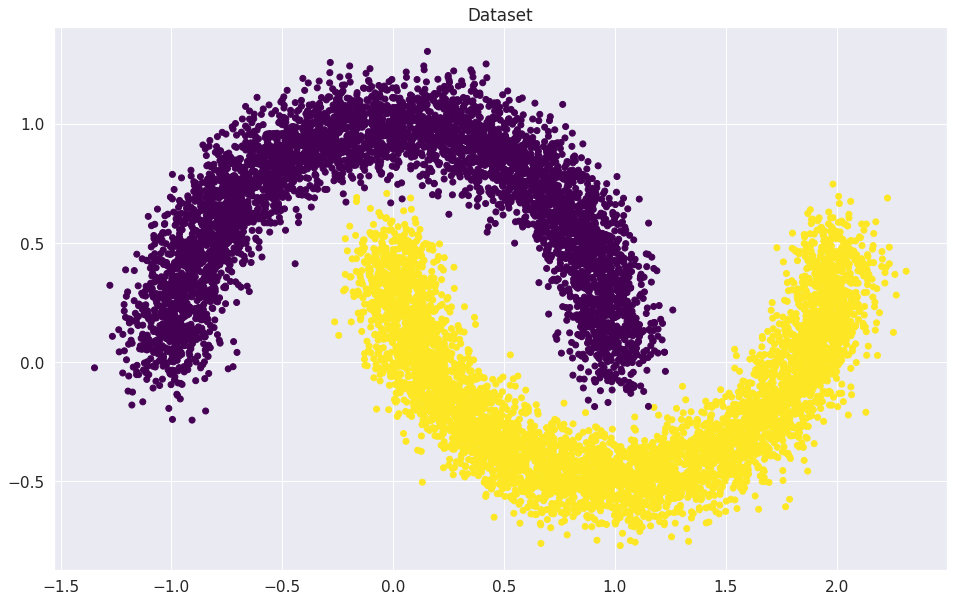

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [6]:
print(X_train[0].dtype)

float64


In [7]:
X_train_t = torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train) # YOUR CODE GOES HERE
X_val_t = torch.FloatTensor(X_val) # YOUR CODE GOES HERE
y_val_t = torch.FloatTensor(y_val) # YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features)) # YOUR CODE GOES HERE
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.ones(1, out_features)) # YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss() # doing Sigmoid and then Binary Cross Entropy 
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [11]:
#YOUR CODE
in_features = 2
out_features = 1
bias = True
print(f'THERE ARE {in_features * out_features + out_features * bias} PARAMETERS')

THERE ARE 3 PARAMETERS


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp.flatten(), y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0]) # <=> requires_grad = false + reshape(1, -1)
        optimizer.step()
        probabilities =  torch.sigmoid(outp)# YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.59375
Iteration: 100
Batch accuracy: 0.734375
Iteration: 200
Batch accuracy: 0.75
Iteration: 300
Batch accuracy: 0.8046875
Iteration: 400
Batch accuracy: 0.78125
Iteration: 500
Batch accuracy: 0.8671875
Iteration: 600
Batch accuracy: 0.8359375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125

Iteration: 877.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:**

In [13]:
print(f'получается что {it + epoch * len(train_dataloader)}')

получается что 877


### Визуализируем результаты

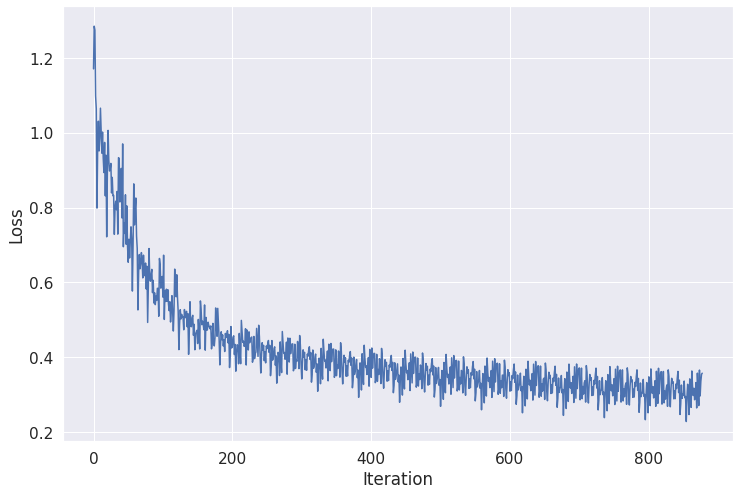

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

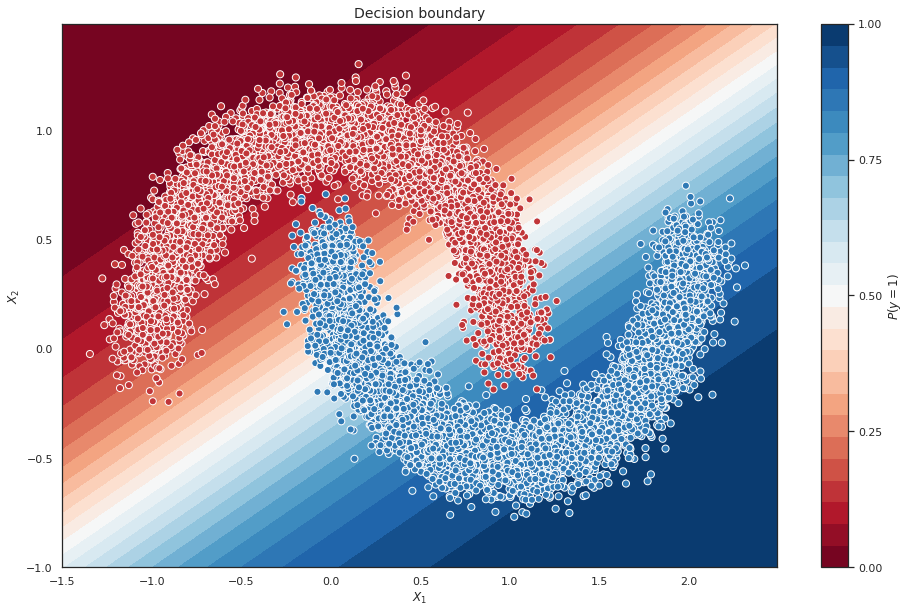

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        probs = torch.sigmoid(model.forward(x_batch))
        preds = (probs > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
y_preds = predict(val_dataloader, linear_regression)

print(accuracy_score(y_val, y_preds))

0.8552


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [18]:
from torchvision import transforms as tfs

In [29]:
import os
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=64, # можно 128 т.к. в примере 10 эпох
                                          shuffle=True, num_workers=2) # YOUR CODE GOES HERE
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                         shuffle=False, num_workers=2) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [30]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
x, y = next(iter(train_dataloader))
print(x.shape)
x = x.flatten(1)
print(x.shape)
print(y.shape)
print(x.device)
print(y)

torch.Size([64, 1, 28, 28])
torch.Size([64, 784])
torch.Size([64])
cpu
tensor([2, 3, 3, 5, 4, 8, 3, 2, 4, 9, 7, 4, 3, 6, 7, 3, 4, 1, 7, 4, 2, 3, 1, 1,
        0, 3, 4, 9, 5, 7, 4, 7, 6, 1, 6, 8, 6, 0, 4, 0, 1, 2, 8, 1, 0, 9, 3, 1,
        1, 0, 1, 0, 2, 4, 2, 6, 7, 8, 4, 8, 7, 2, 1, 0])


In [33]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(), #start dim = 1 by default
    # 784
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)#.to(device)

In [34]:
criterion = nn.BCEWithLogitsLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [35]:
a = torch.zeros(2)
print(a)
b = a.clone()
b[0] = 10
print(a)
print(b)
print(torch.sum(b == 10))
print(b[0])
print(len(b))

tensor([0., 0.])
tensor([0., 0.])
tensor([10.,  0.])
tensor(1)
tensor(10.)
2


In [36]:
model = model.to(device)

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 logits = model(x_batch.to(device))
                 #print(y_batch.shape) #should be (4 x 10) bit it is (4)
                 
                 #танцы с бубном
                 batch_sz = y_batch.shape[0]
                 y_batch_temp = torch.zeros(batch_sz, 10)
                 indices = (torch.arange(batch_sz), y_batch.type(torch.long))
                 value = torch.ones(batch_sz)
                 y_batch_temp.index_put_(indices, value) #для нормальной работы binary cross entropy
                 
                 loss = criterion(logits, y_batch_temp.to(device))
                 loss.backward()
                 optimizer.step()
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                     logits = model(x_batch.to(device))
            
            outp = torch.sigmoid(logits)
            preds = outp.argmax(-1)
            #print(preds)
            #print(y_batch)
            correct = torch.sum(preds.cpu() == y_batch) # YOUR CODE GOES HERE
            all = len(preds) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8818166666666667
Loader: valid. Accuracy: 0.9339
Epoch: 2
Loader: train. Accuracy: 0.95285
Loader: valid. Accuracy: 0.9604
Epoch: 3
Loader: train. Accuracy: 0.9675
Loader: valid. Accuracy: 0.9674
Epoch: 4
Loader: train. Accuracy: 0.97435
Loader: valid. Accuracy: 0.9688
Epoch: 5
Loader: train. Accuracy: 0.9787
Loader: valid. Accuracy: 0.9732
Epoch: 6
Loader: train. Accuracy: 0.9811333333333333
Loader: valid. Accuracy: 0.974
Epoch: 7
Loader: train. Accuracy: 0.9836166666666667
Loader: valid. Accuracy: 0.9777
Epoch: 8
Loader: train. Accuracy: 0.9863
Loader: valid. Accuracy: 0.9776
Epoch: 9
Loader: train. Accuracy: 0.9877666666666667
Loader: valid. Accuracy: 0.9768
Epoch: 10
Loader: train. Accuracy: 0.9883333333333333
Loader: valid. Accuracy: 0.9785


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [52]:
elu_accuracy = accuracy["valid"]

In [54]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)
from tqdm import tqdm_notebook

def test_activation_function(activation):
    model = nn.Sequential(
    nn.Flatten(), #start dim = 1 by default
    # 784
    #YOUR CODE. Add layers to your sequential class
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10))

    criterion = nn.BCEWithLogitsLoss() #YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    model = model.to(device)

    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in tqdm_notebook(range(max_epochs)):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    logits = model(x_batch.to(device))
                    #print(y_batch.shape) #should be (4 x 10) bit it is (4)
                    
                    #танцы с бубном
                    batch_sz = y_batch.shape[0]
                    y_batch_temp = torch.zeros(batch_sz, 10)
                    indices = (torch.arange(batch_sz), y_batch.type(torch.long))
                    value = torch.ones(batch_sz)
                    y_batch_temp.index_put_(indices, value) #для нормальной работы binary cross entropy
                    
                    loss = criterion(logits, y_batch_temp.to(device))
                    loss.backward()
                    optimizer.step()
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        logits = model(x_batch.to(device))
                
                outp = torch.sigmoid(logits)
                preds = outp.argmax(-1)
                #print(preds)
                #print(y_batch)
                correct = torch.sum(preds.cpu() == y_batch) # YOUR CODE GOES HERE
                all = len(preds) # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [55]:
plain_accuracy = test_activation_function(Identical)['valid']
relu_accuracy = test_activation_function(nn.ReLU)['valid'] #YOUR CODE
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)['valid'] #YOUR CODE

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8639333333333333
Loader: valid. Accuracy: 0.9032
Epoch: 2
Loader: train. Accuracy: 0.8965333333333333
Loader: valid. Accuracy: 0.9113
Epoch: 3
Loader: train. Accuracy: 0.9019166666666667
Loader: valid. Accuracy: 0.9143
Epoch: 4
Loader: train. Accuracy: 0.9034166666666666
Loader: valid. Accuracy: 0.9042
Epoch: 5
Loader: train. Accuracy: 0.9058166666666667
Loader: valid. Accuracy: 0.9115
Epoch: 6
Loader: train. Accuracy: 0.9059833333333334
Loader: valid. Accuracy: 0.9065
Epoch: 7
Loader: train. Accuracy: 0.9080666666666667
Loader: valid. Accuracy: 0.9085
Epoch: 8
Loader: train. Accuracy: 0.9081333333333333
Loader: valid. Accuracy: 0.9113
Epoch: 9
Loader: train. Accuracy: 0.9075833333333333
Loader: valid. Accuracy: 0.9137
Epoch: 10
Loader: train. Accuracy: 0.9096666666666666
Loader: valid. Accuracy: 0.9149


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8635666666666667
Loader: valid. Accuracy: 0.9278
Epoch: 2
Loader: train. Accuracy: 0.9402833333333334
Loader: valid. Accuracy: 0.9535
Epoch: 3
Loader: train. Accuracy: 0.9574833333333334
Loader: valid. Accuracy: 0.9626
Epoch: 4
Loader: train. Accuracy: 0.9659666666666666
Loader: valid. Accuracy: 0.9665
Epoch: 5
Loader: train. Accuracy: 0.9719
Loader: valid. Accuracy: 0.9693
Epoch: 6
Loader: train. Accuracy: 0.97415
Loader: valid. Accuracy: 0.971
Epoch: 7
Loader: train. Accuracy: 0.9775333333333334
Loader: valid. Accuracy: 0.972
Epoch: 8
Loader: train. Accuracy: 0.9806166666666667
Loader: valid. Accuracy: 0.9723
Epoch: 9
Loader: train. Accuracy: 0.98105
Loader: valid. Accuracy: 0.9716
Epoch: 10
Loader: train. Accuracy: 0.9834833333333334
Loader: valid. Accuracy: 0.9715


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Loader: train. Accuracy: 0.8744833333333333
Loader: valid. Accuracy: 0.9417
Epoch: 2
Loader: train. Accuracy: 0.9478166666666666
Loader: valid. Accuracy: 0.9413
Epoch: 3
Loader: train. Accuracy: 0.9637
Loader: valid. Accuracy: 0.9644
Epoch: 4
Loader: train. Accuracy: 0.97085
Loader: valid. Accuracy: 0.9696
Epoch: 5
Loader: train. Accuracy: 0.9739666666666666
Loader: valid. Accuracy: 0.9706
Epoch: 6
Loader: train. Accuracy: 0.97785
Loader: valid. Accuracy: 0.9766
Epoch: 7
Loader: train. Accuracy: 0.9819
Loader: valid. Accuracy: 0.9752
Epoch: 8
Loader: train. Accuracy: 0.9826333333333334
Loader: valid. Accuracy: 0.9747
Epoch: 9
Loader: train. Accuracy: 0.98515
Loader: valid. Accuracy: 0.9765
Epoch: 10
Loader: train. Accuracy: 0.98665
Loader: valid. Accuracy: 0.9746


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

In [56]:
print(plain_accuracy)
print(relu_accuracy)
print(leaky_relu_accuracy)

[0.9032, 0.9113, 0.9143, 0.9042, 0.9115, 0.9065, 0.9085, 0.9113, 0.9137, 0.9149]
[0.9278, 0.9535, 0.9626, 0.9665, 0.9693, 0.971, 0.972, 0.9723, 0.9716, 0.9715]
[0.9417, 0.9413, 0.9644, 0.9696, 0.9706, 0.9766, 0.9752, 0.9747, 0.9765, 0.9746]


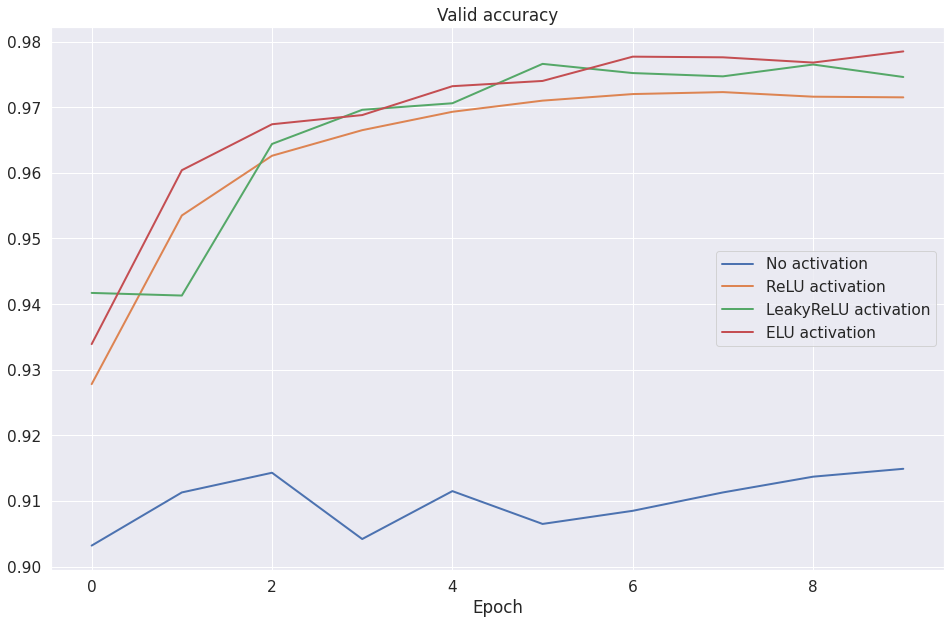

In [57]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

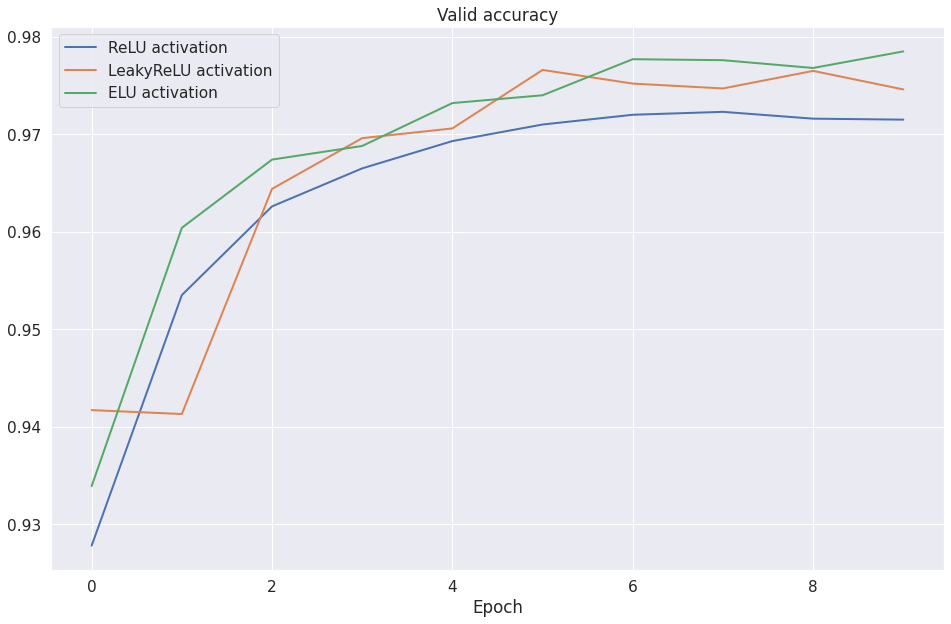

In [58]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:**

# ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = #YOUR CODE
        self.conv2 = #YOUR CODE
        self.pool2 = #YOUR CODE
        self.fc1 = #YOUR CODE  
        self.fc2 = #YOUR CODE
        self.fc3 = #YOUR CODE

    def forward(self, x):
        x = #YOUR CODE. Apply layers created in __init__. 
        ...
        return x

In [ ]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
<YOUR CODE>

In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**